In [1]:
import control as ctrl
import numpy as np
import pandas as pd
from IPython.display import display
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams["text.usetex"] = True
rcParams["font.family"] = "serif"

In [2]:
[Kp, Ki, Kd, s, a, b, K] = sp.symbols("Kp Ki Kd s a b K")
[p1, p2, p3] = sp.symbols("p1 p2 p3")

# Desired characteristic polynomial
desired_poly = sp.Poly((s + p1) * (s + p2) * (s + p3), s)
desired_coeffs = desired_poly.all_coeffs()

# System characteristic polynomial: s^3 + (a + K*Kd)*s^2 + (b + K*Kp)*s + K*Ki
# Coefficient matching directly
Kd = (desired_coeffs[1] - a) / K
Kp = (desired_coeffs[2] - b) / K
Ki = desired_coeffs[3] / K
gains = {"Kp": Kp, "Ki": Ki, "Kd": Kd}

for gain_name, gain_expr in gains.items():
    display(sp.Eq(sp.symbols(gain_name), gain_expr))


def compute_pid_gains(a_val, b_val, K_val, p1_val, p2_val, p3_val):
    subs = {
        sp.symbols("a"): a_val,
        sp.symbols("b"): b_val,
        sp.symbols("K"): K_val,
        p1: p1_val,
        p2: p2_val,
        p3: p3_val,
    }
    Kd_val = sp.simplify(gains["Kd"].subs(subs))
    Kp_val = sp.simplify(gains["Kp"].subs(subs))
    Ki_val = sp.simplify(gains["Ki"].subs(subs))

    return float(Kp_val), float(Ki_val), float(Kd_val)

Eq(Kp, (-b + p1*p2 + p1*p3 + p2*p3)/K)

Eq(Ki, p1*p2*p3/K)

Eq(Kd, (-a + p1 + p2 + p3)/K)

<TransferFunction>: sys[6]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

         5
  ---------------
  s^2 + 10 s + 20


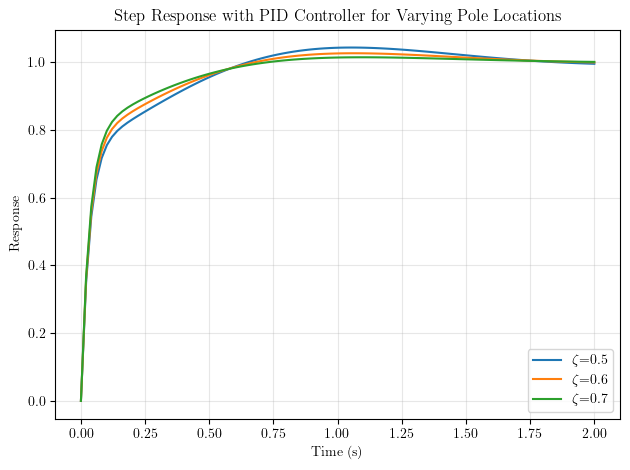

<TransferFunction>: sys[6]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

         5
  ---------------
  s^2 + 10 s + 20


,zeta,p1,p2,p3,Kp,Ki,Kd
0,0.5,1.5 + 2.6*I,1.5 - 2.6*I,30,15.8,54.0,4.60
1,0.6,1.8 + 2.4*I,1.8 - 2.4*I,30,19.4,54.0,4.72
2,0.7,2.1 + 2.14*I,2.1 - 2.14*I,30,23.0,54.0,4.84


In [3]:
s = ctrl.tf("s")
G = 5 / (s + 7.236) / (s + 2.764)
print(G)
[num, den] = ctrl.tfdata(G)
t, y = ctrl.step_response(G)
K = num[0][0].tolist()[0]
num = np.squeeze(num)
den = np.squeeze(den)
a = den[1]
b = den[2]
omega_n = 3
p3_val = omega_n * 10

gains_names = ["Kp", "Ki", "Kd"]
gains_vals = []
plt.figure()
for zeta in np.arange(0.5, 0.701, 0.1, dtype=float):
    p1_val = omega_n * (zeta + sp.sqrt(zeta**2 - 1))
    p2_val = omega_n * (zeta - sp.sqrt(zeta**2 - 1))
    Kp, Ki, Kd = compute_pid_gains(a, b, K, p1_val, p2_val, p3_val)
    C = ctrl.tf([Kd, Kp, Ki], [1, 0])
    T = ctrl.feedback(G * C, 1)
    t, y = ctrl.step_response(T, np.linspace(0, 2, 100))
    plt.plot(t, y, label=rf"$\zeta$={round(zeta, 2)}")

    gains_vals.append(
        {
            "zeta": round(zeta, 2),
            "p1": round(p1_val, 2),
            "p2": round(p2_val, 2),
            "p3": round(p3_val, 2),
            "Kp": round(Kp, 2),
            "Ki": round(Ki, 2),
            "Kd": round(Kd, 2),
        }
    )
gains_df = pd.DataFrame(gains_vals, columns=["zeta", "p1", "p2", "p3"] + gains_names)

plt.title("Step Response with PID Controller for Varying Pole Locations")
plt.xlabel("Time (s)")
plt.ylabel("Response")
plt.grid(alpha=0.3)
plt.legend(loc="best")
plt.tight_layout()
plt.show()
print(G)
display(gains_df)